In [1]:
# !git clone -b geral https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [2]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
torch.__version__

'2.0.0+cu118'

In [3]:
def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 8
    args.margin_loss = 2.0
    args.border  = 15
    args.nms_size = 40 # normal é 10, alterei so pra avaliar o match
    args.exported = False
    return args

In [4]:
args = custom_config(args)
n_bin = 6
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)

In [5]:
from training import KeyEqGroup, KeyPointsSelection, remove_borders, random_augmentation, shifted_batch_tensor
from utils import load_model, imshow, imshow2, imshow3,NMSHead


MODEL_PATH = "./data/models/model_flowers_ssim.pt"

model = load_model_trained(args,device,path=MODEL_PATH)

c:\Users\renga\PycharmProjects\singular_points\venv\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)


Já foi treinado
epoca 32 loss 3.516438318233865


In [6]:
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

8 tensor([0, 0, 0, 0, 0, 0, 0, 0])


pos predict  torch.Size([8, 1, 180, 180]) torch.Size([8, 36, 180, 180])


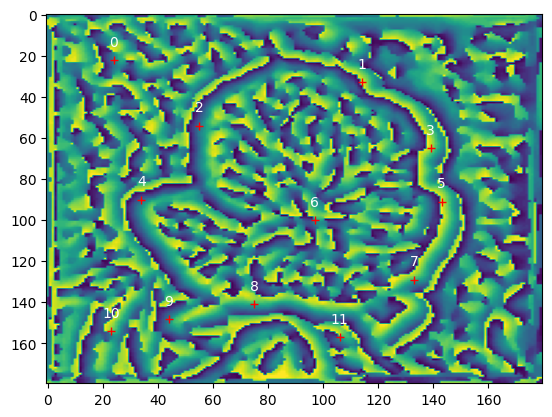

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [7]:
batch_result,feature,orien1,coords = predict_single_points(model,batch)

In [8]:
print('QTD batch ',len(batch_result))
for i,b in enumerate(batch_result):
    boxs,mini_feat_batch,mini_orien_batch =b
    print('batch ',i,' boxs ',len(boxs),' mini_feat_batch ',mini_feat_batch.shape,' mini_orien_batch ',mini_orien_batch.shape)

QTD batch  8
batch  0  boxs  2  mini_feat_batch  torch.Size([12, 21, 21])  mini_orien_batch  torch.Size([12, 21, 21])
batch  1  boxs  2  mini_feat_batch  torch.Size([9, 21, 21])  mini_orien_batch  torch.Size([9, 21, 21])
batch  2  boxs  2  mini_feat_batch  torch.Size([8, 21, 21])  mini_orien_batch  torch.Size([8, 21, 21])
batch  3  boxs  2  mini_feat_batch  torch.Size([10, 21, 21])  mini_orien_batch  torch.Size([10, 21, 21])
batch  4  boxs  2  mini_feat_batch  torch.Size([12, 21, 21])  mini_orien_batch  torch.Size([12, 21, 21])
batch  5  boxs  2  mini_feat_batch  torch.Size([8, 21, 21])  mini_orien_batch  torch.Size([8, 21, 21])
batch  6  boxs  2  mini_feat_batch  torch.Size([9, 21, 21])  mini_orien_batch  torch.Size([9, 21, 21])
batch  7  boxs  2  mini_feat_batch  torch.Size([7, 21, 21])  mini_orien_batch  torch.Size([7, 21, 21])


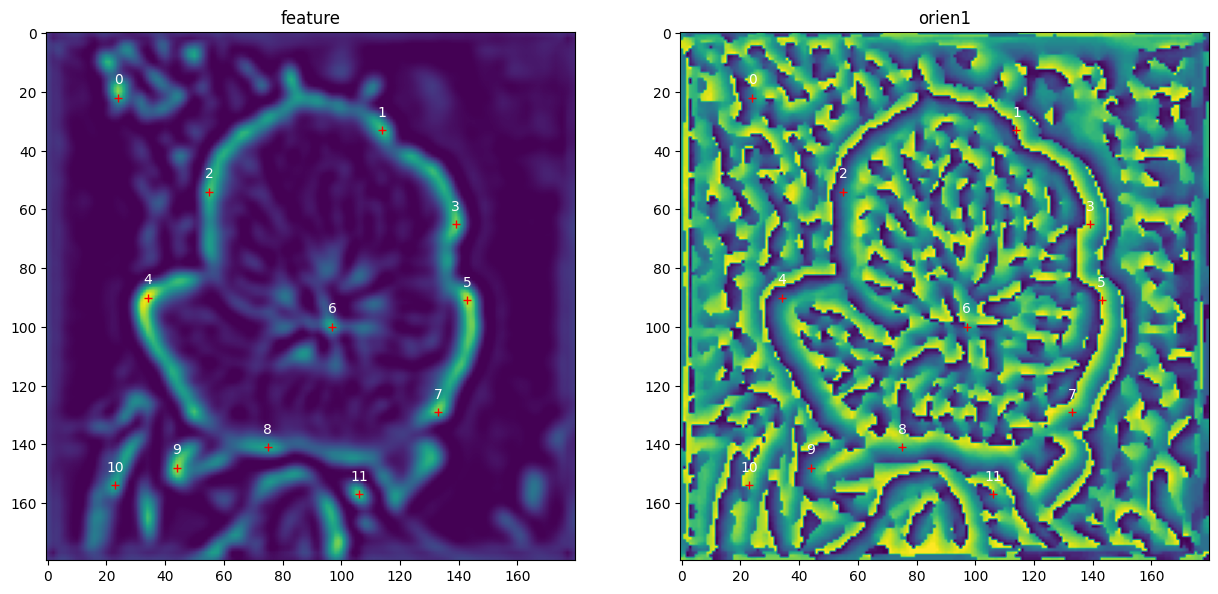

In [9]:
#exibe duas imagens lado a lado com matplotlib com dois titulos
def imshow2(img1,img2,coords=None,t1="0",t2="1",figsize=(15,10)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img1)
    ax1.title.set_text(t1)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img2)
    ax2.title.set_text(t2)
    if coords is not None:
        ax1.plot(coords[0,:],coords[1,:], 'r+')
        ax2.plot(coords[0,:],coords[1,:], 'r+')
        # zip joins x and y coordinates in pairs
        labels = np.arange(coords.shape[1])
        for i, (x,y) in enumerate(zip(coords[0,:],coords[1,:])):
            ax1.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
            
            ax2.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
    plt.show()



imshow2(feature[0,0].cpu().detach(),orien1[0].cpu().detach(),coords[0],t1='feature',t2='orien1')



In [10]:
def plot_histogram(hist,ax):
    ax.bar(np.arange(len(hist)),hist)
    #colocar labels
    n_bin = len(hist)
    angle = 360/n_bin
    labels = ["{}-{}".format(int(i*angle),int((i+1)*angle)) for i in range(n_bin)]
    ax.set_xticks(np.arange(len(hist)))
    ax.set_xticklabels(labels)
    #titulo nos eixos
    ax.set_xlabel('Bins')
    ax.set_ylabel('Intensity')


#exibe duas imagens lado a lado com matplotlib com dois titulos
def imshow_features_hist(img1,img2,hist=None,index="0",figsize=(14,3)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(img1,aspect='auto')
    ax1.title.set_text('feat i:'+index)
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(img2,aspect='auto')
    ax2.title.set_text('orie i:'+index)
    if hist is not None:
        ax3 = fig.add_subplot(1,3,3)
        plot_histogram(hist,ax3)
    plt.show()

batch  0  QTD features  torch.Size([12, 21, 21])
tensor(0., device='cuda:0') tensor(350., device='cuda:0')
<class 'numpy.ndarray'> (21, 21)
interval : 0  -  60


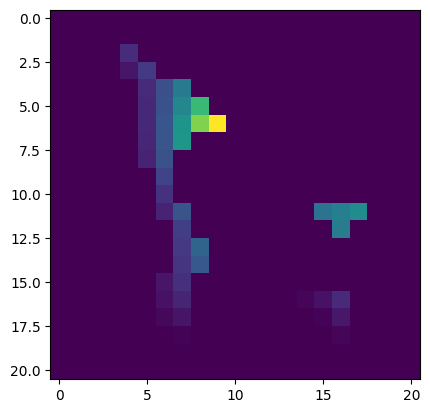

interval : 60  -  120


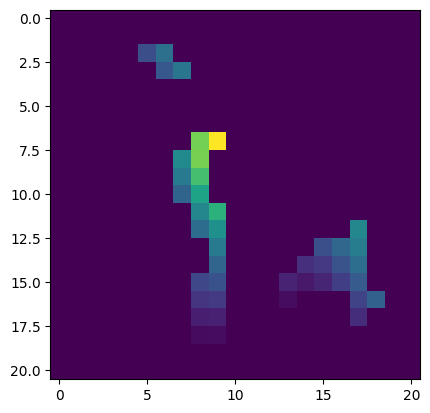

interval : 120  -  180


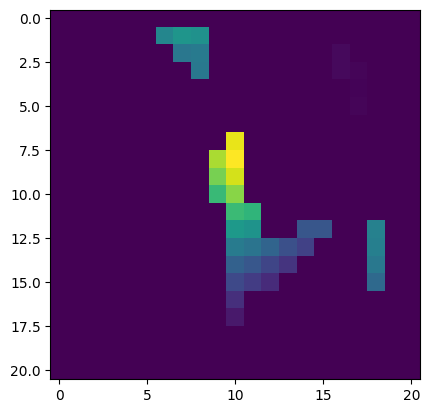

interval : 180  -  240


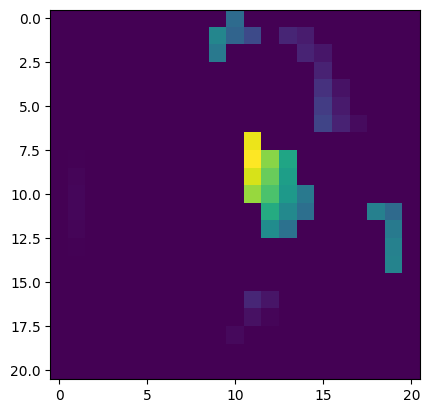

interval : 240  -  300


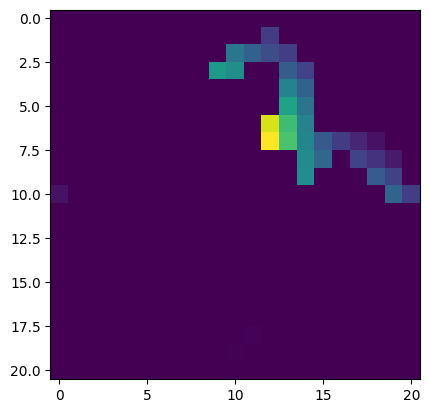

interval : 300  -  360


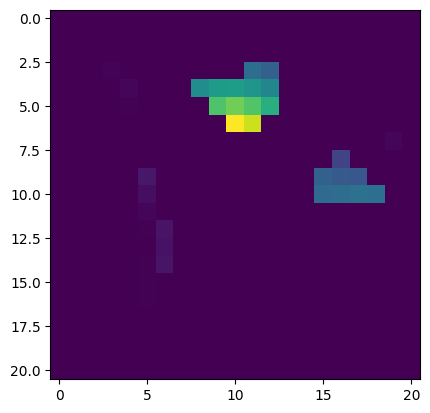

torch.Size([12, 6])


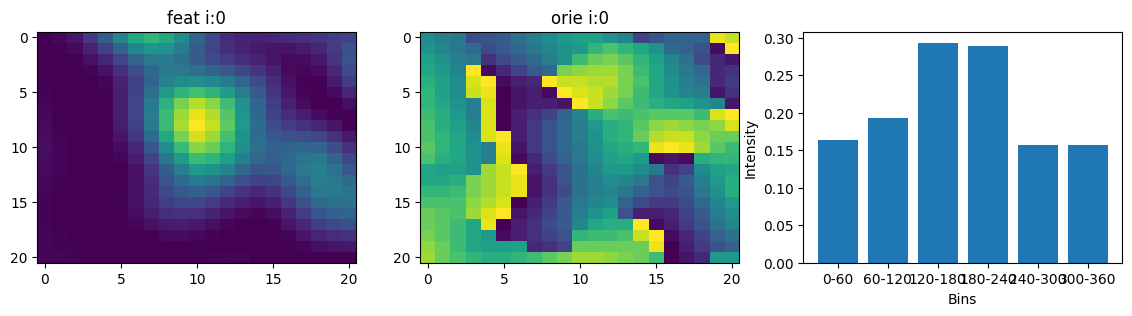

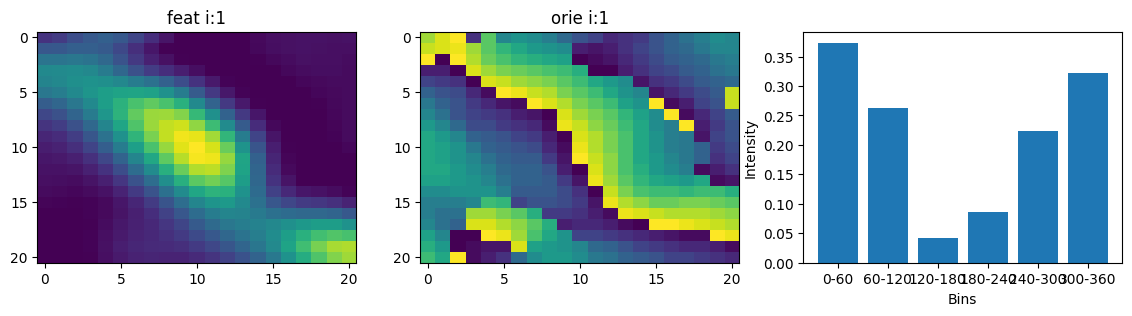

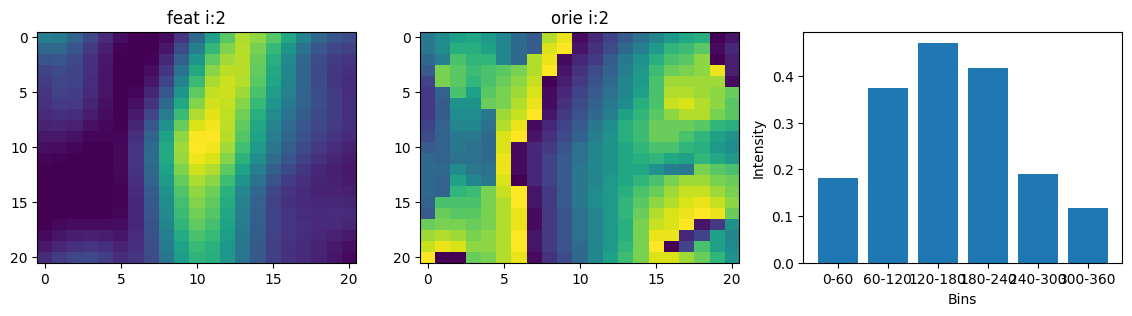

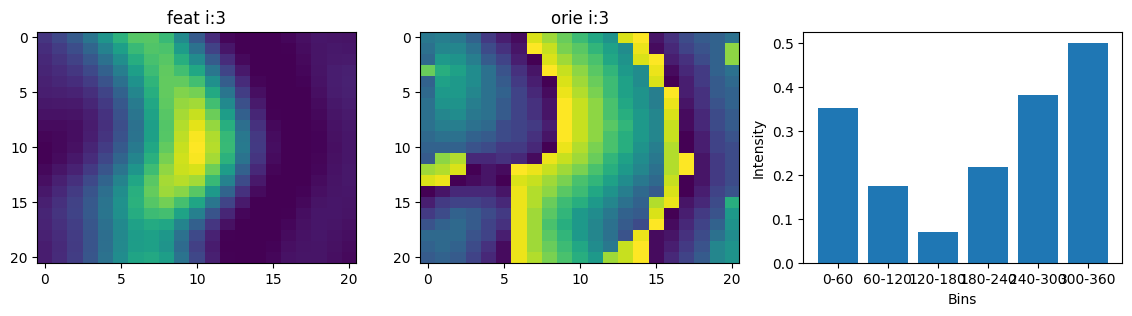

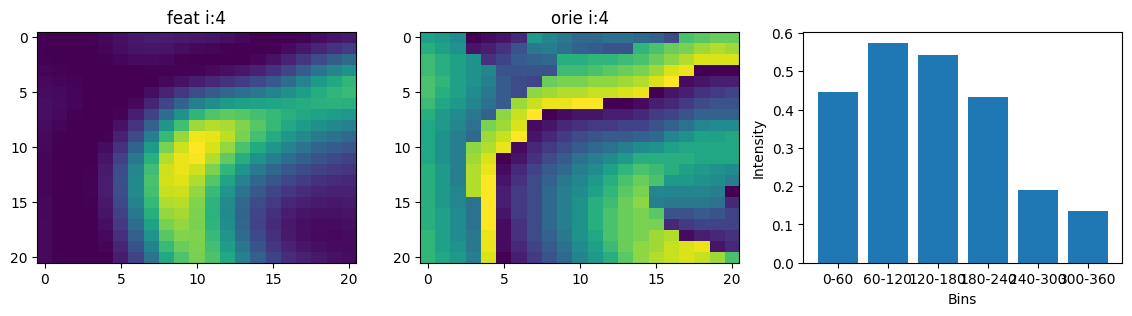

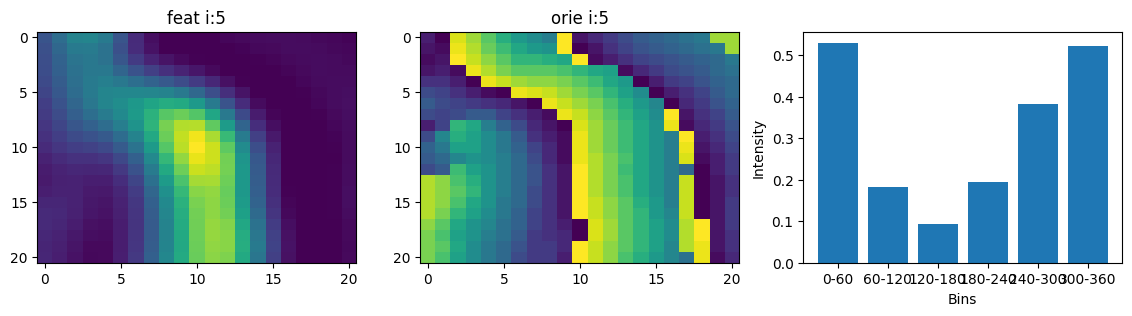

In [11]:
from utils import build_histogram_orientation
from utils import create_circular_mask

circular_mask = create_circular_mask(21,21)

for i,(boxs,mini_feat_batch,mini_orien_batch) in enumerate(batch_result):
    print('batch ',i,' QTD features ', mini_feat_batch.shape)
    temp_feat = mini_feat_batch[None].permute(1,0,2,3)
    hist1_b = build_histogram_orientation(mini_orien_batch,temp_feat,circular_mask,n_bin,show=True)        
    print(hist1_b.shape)
    for j in range(mini_orien_batch.shape[0]):        
        if j>5:            
            break        
        imshow_features_hist(temp_feat[j][0].cpu().detach(),mini_orien_batch[j].cpu().detach(),hist1_b[j].cpu().detach(),index=str(j),figsize=(14,3))

    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


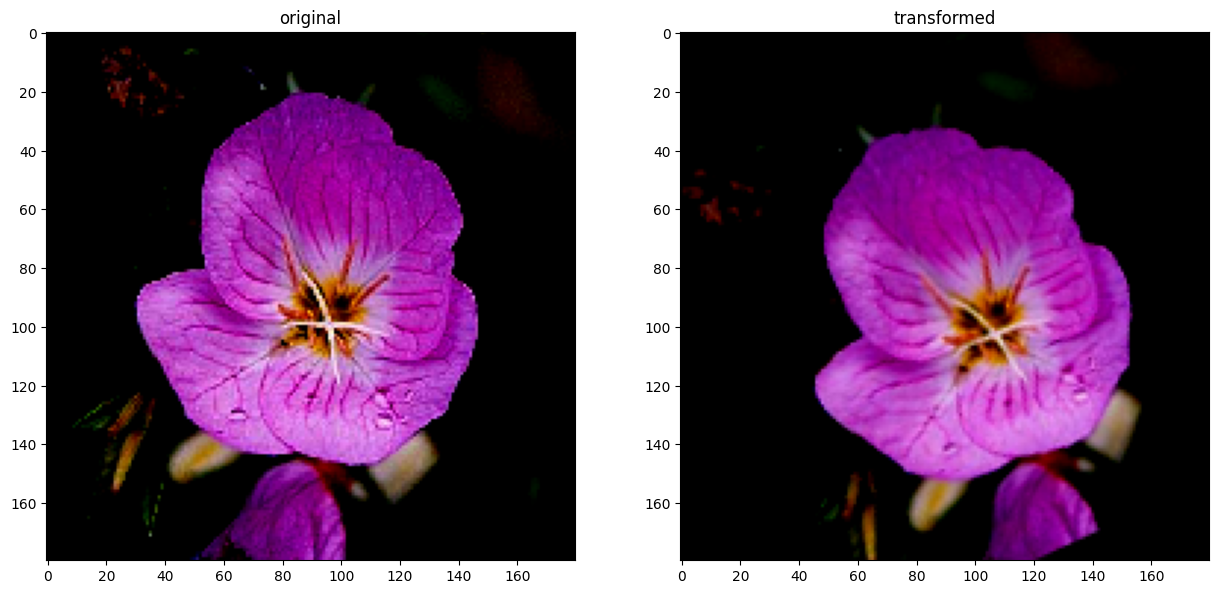

In [12]:
import kornia as K


augme_affim =K.augmentation.RandomAffine(degrees=[-90, 90],translate=[0.05,0.05], p=1.,same_on_batch=True,keepdim=True)
augm_pespec =K.augmentation.RandomPerspective(distortion_scale=0.05, p=1.,same_on_batch=True,keepdim=True)
aug_compost = K.augmentation.AugmentationSequential(
                    augm_pespec,
                    augme_affim,
                    data_keys=["input"]
                )


img_batch, labels =batch
img_trans= aug_compost(img_batch)
imshow2(img_batch[0].permute(1,2,0).cpu().detach(),img_trans[0].permute(1,2,0).cpu().detach(),t1='original',t2='transformed')
# img_trans to new batch with labels
new_batch = (img_trans, labels)


pos predict  torch.Size([8, 1, 180, 180]) torch.Size([8, 36, 180, 180])


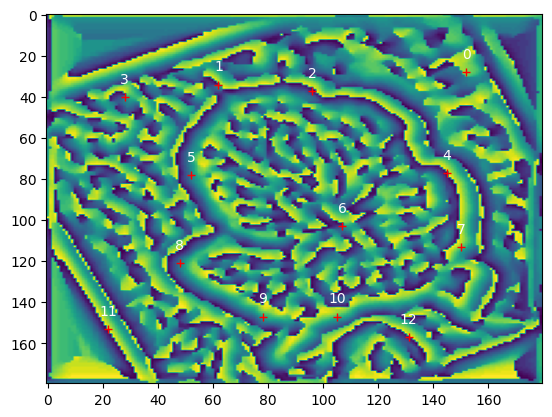

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


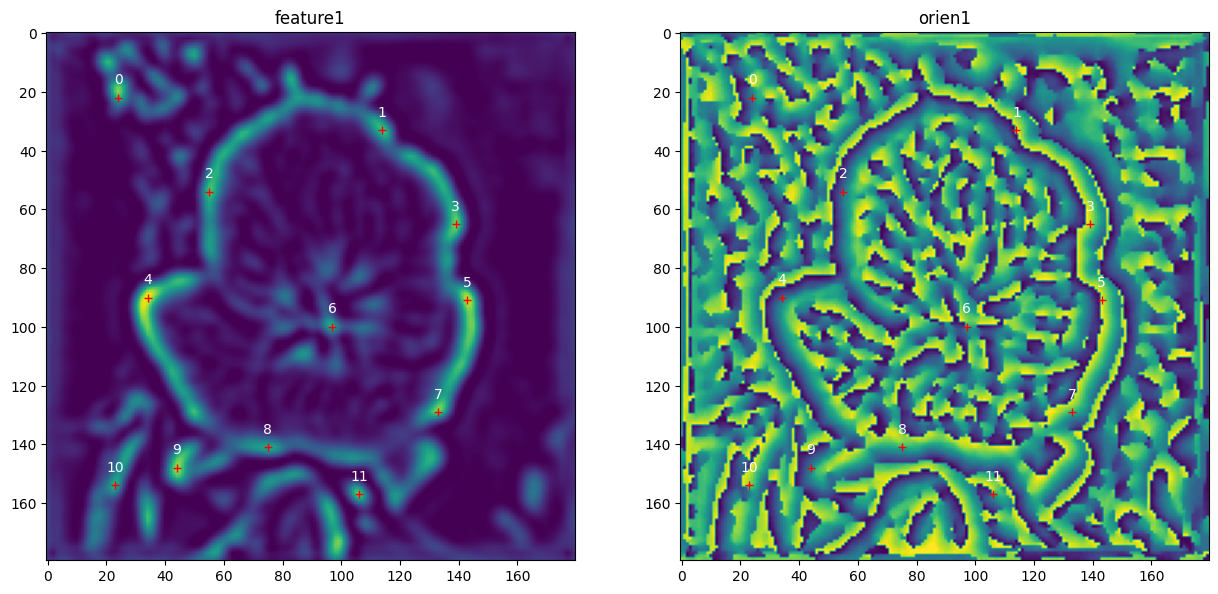

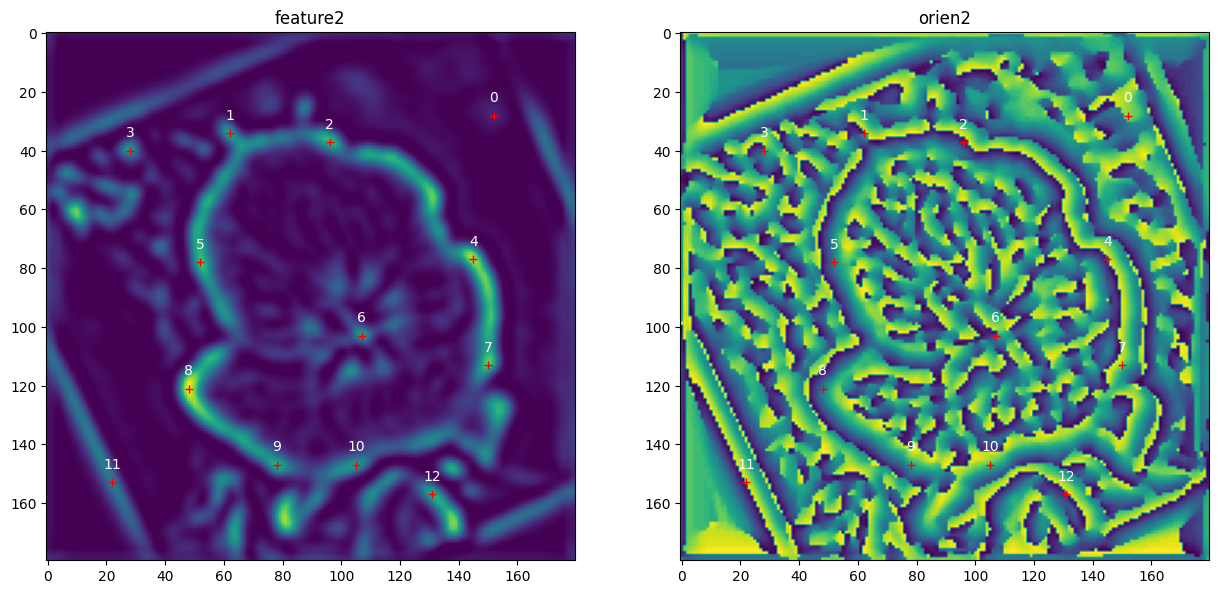

In [13]:
batch_result2,feature2,orien2,coords2 = predict_single_points(model,new_batch)

imshow2(feature[0,0].cpu().detach(),orien1[0].cpu().detach(),coords[0],t1='feature1',t2='orien1')
imshow2(feature2[0,0].cpu().detach(),orien2[0].cpu().detach(),coords2[0],t1='feature2',t2='orien2')

batch  0  QTD features  torch.Size([13, 21, 21])
tensor(0., device='cuda:0') tensor(350., device='cuda:0')
<class 'numpy.ndarray'> (21, 21)
interval : 0  -  60
interval : 60  -  120
interval : 120  -  180
interval : 180  -  240
interval : 240  -  300
interval : 300  -  360
torch.Size([13, 6])


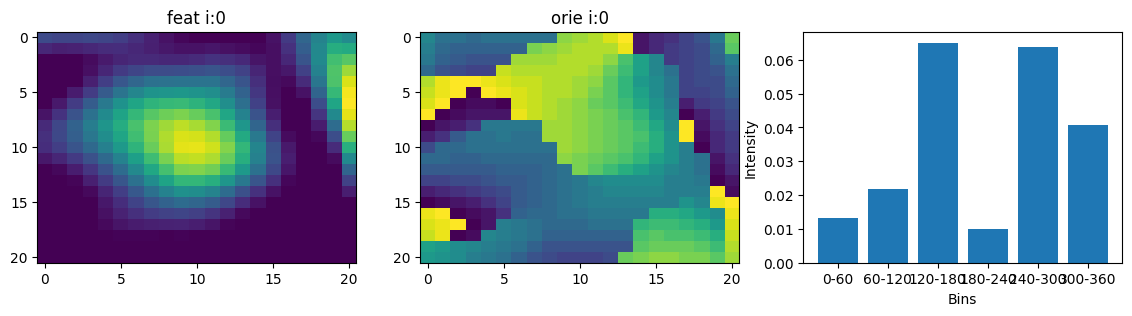

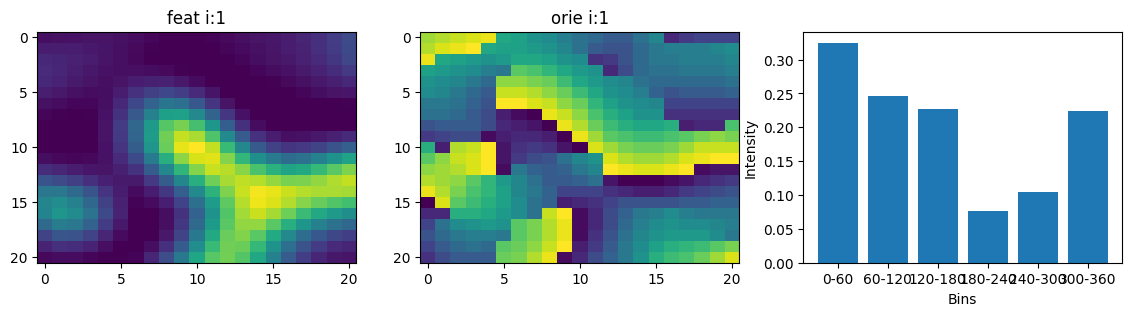

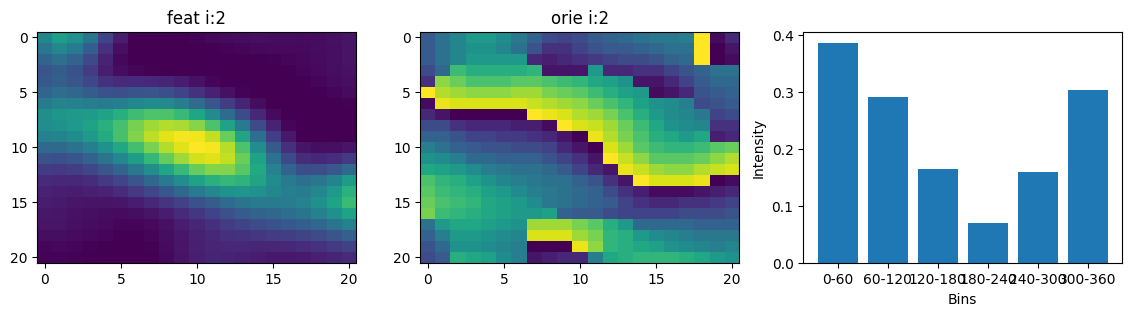

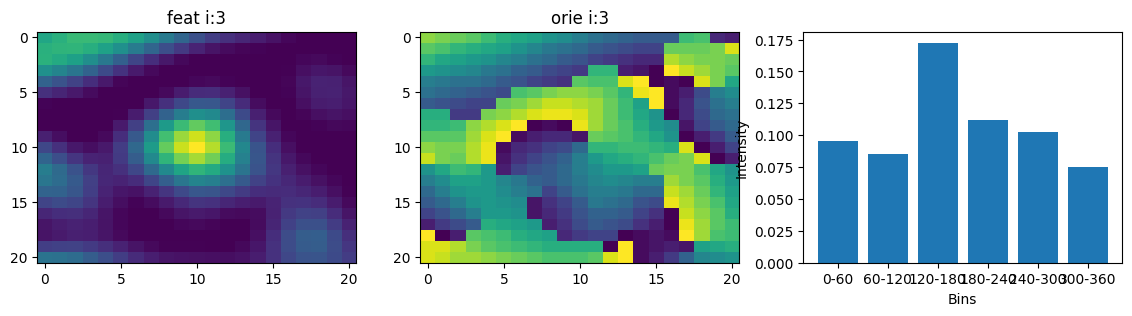

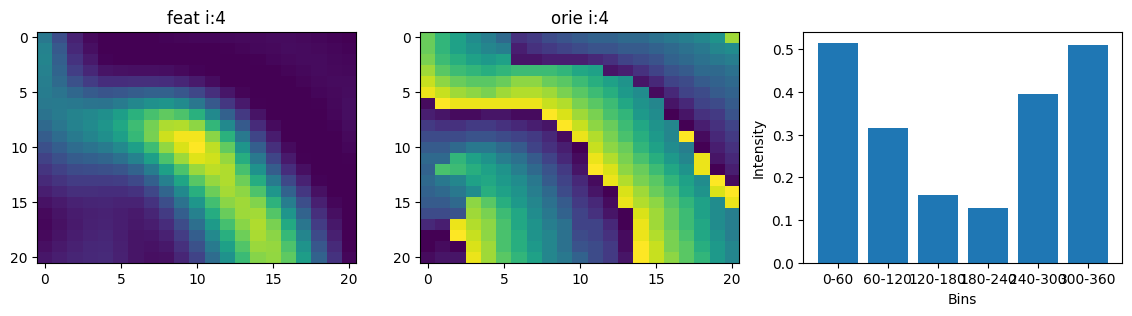

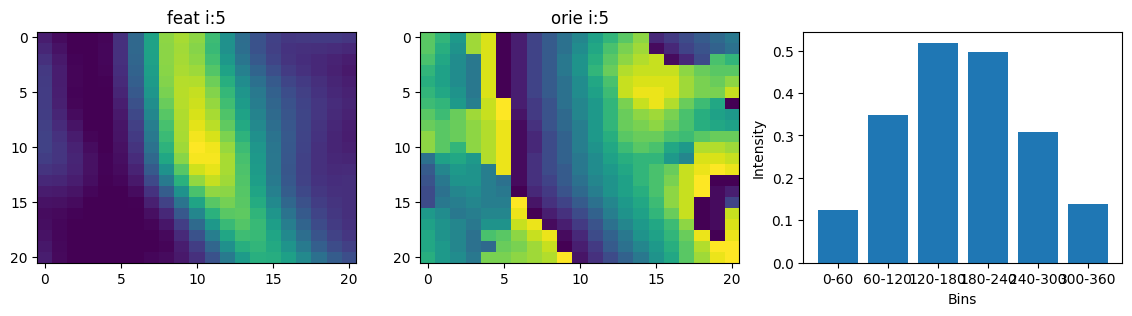

tensor([[0.0131, 0.0218, 0.0650, 0.0100, 0.0638, 0.0408],
        [0.3250, 0.2467, 0.2269, 0.0762, 0.1047, 0.2235],
        [0.3861, 0.2902, 0.1641, 0.0692, 0.1593, 0.3024],
        [0.0956, 0.0856, 0.1725, 0.1115, 0.1022, 0.0753],
        [0.5154, 0.3147, 0.1589, 0.1284, 0.3942, 0.5105],
        [0.1235, 0.3484, 0.5185, 0.4975, 0.3072, 0.1376],
        [0.1989, 0.1736, 0.1023, 0.1089, 0.1658, 0.1808],
        [0.2462, 0.1716, 0.1678, 0.2468, 0.4819, 0.4160],
        [0.3140, 0.6007, 0.6406, 0.6016, 0.2868, 0.0865],
        [0.0871, 0.1484, 0.3283, 0.4293, 0.3372, 0.1939],
        [0.1651, 0.0683, 0.1533, 0.2983, 0.4002, 0.3269],
        [0.2869, 0.1597, 0.0680, 0.0505, 0.1923, 0.2913],
        [0.3731, 0.3926, 0.0922, 0.0488, 0.2157, 0.3594]], device='cuda:0')

In [14]:
for i,(boxs,mini_feat_batch,mini_orien_batch) in enumerate(batch_result2):
    print('batch ',i,' QTD features ', mini_feat_batch.shape)
    temp_feat = mini_feat_batch[None].permute(1,0,2,3)
    hist2_b = build_histogram_orientation(mini_orien_batch,temp_feat,circular_mask,n_bin,show=False)        
    print(hist2_b.shape)
    for j in range(mini_orien_batch.shape[0]):        
        if j>5:            
            break        
        imshow_features_hist(temp_feat[j][0].cpu().detach(),mini_orien_batch[j].cpu().detach(),hist2_b[j].cpu().detach(),index=str(j),figsize=(14,3))

    break
hist2_b

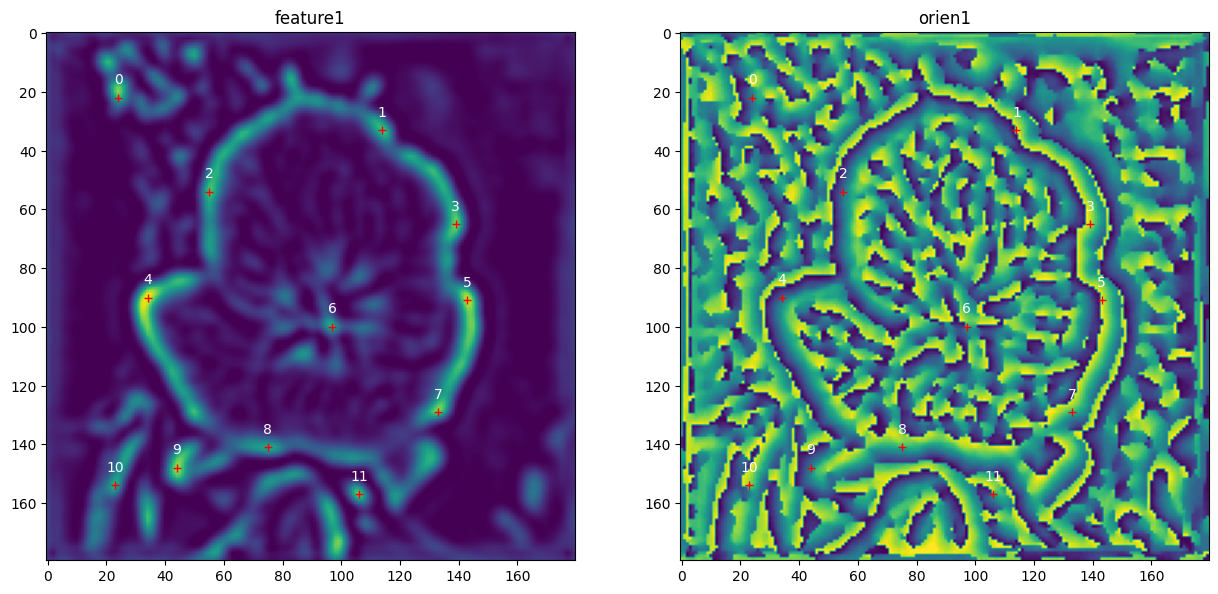

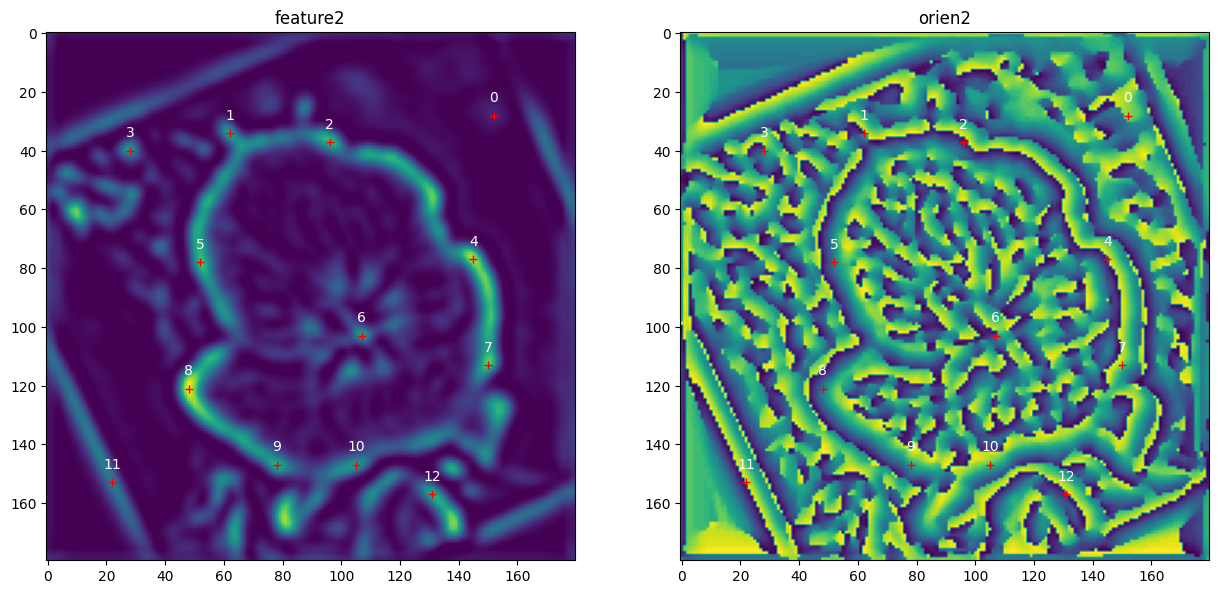

index:  0  found in  6  position 
index:  1  found in  12  position 
index:  2  found in  5  position 
index:  3  found in  7  position 
index:  4  found in  8  position 
index:  5  found in  4  position 
index:  6  found in  6  position 
index:  7  found in  10  position 
index:  8  found in  9  position 
index:  9  found in  5  position 
index:  10  found in  2  position 
index:  11  found in  6  position 


In [15]:
imshow2(feature[0,0].cpu().detach(),orien1[0].cpu().detach(),coords[0],t1='feature1',t2='orien1')
imshow2(feature2[0,0].cpu().detach(),orien2[0].cpu().detach(),coords2[0],t1='feature2',t2='orien2')
# print(hist1_b)
# print(hist2_b)
for i in range(hist1_b.shape[0]):
    d=abs(hist2_b - hist1_b[i])
    diff_hist =torch.sum(d,(1))
    print("index: ",i," found in ",diff_hist.argmin().item()," position ")